In [1]:
!git clone https://github.com/lopeselio/Behavioral-Cloning-Udacity

Cloning into 'Behavioral-Cloning-Udacity'...
remote: Enumerating objects: 7613, done.
remote: Counting objects: 100% (7613/7613), done.
remote: Compressing objects: 100% (7611/7611), done.
remote: Total 7613 (delta 0), reused 7613 (delta 0), pack-reused 0
Receiving objects: 100% (7613/7613), 96.53 MiB | 36.26 MiB/s, done.


In [3]:
!ls Behavioral-Cloning-Udacity


Data  Readme.md


In [4]:
!cd Data

/bin/bash: line 0: cd: Data: No such file or directory


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import ntpath
import random

In [12]:
datadir = 'Behavioral-Cloning-Udacity/Data/'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_559.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_559.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_559.jpg,0.0,0.0,0,2.216956
1,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_661.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_661.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_661.jpg,0.0,0.0,0,2.143898
2,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_765.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_765.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_765.jpg,0.0,0.0,0,2.044709
3,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_868.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_868.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_868.jpg,0.0,0.0,0,1.946553
4,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\center_2020_05_30_15_20_44_970.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\left_2020_05_30_15_20_44_970.jpg,C:\Users\Elio\Desktop\github\Udacity-Behavioral-cloning\Data\IMG\right_2020_05_30_15_20_44_970.jpg,0.0,0.0,0,1.847944


In [14]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_05_30_15_20_44_559.jpg,left_2020_05_30_15_20_44_559.jpg,right_2020_05_30_15_20_44_559.jpg,0.0,0.0,0,2.216956
1,center_2020_05_30_15_20_44_661.jpg,left_2020_05_30_15_20_44_661.jpg,right_2020_05_30_15_20_44_661.jpg,0.0,0.0,0,2.143898
2,center_2020_05_30_15_20_44_765.jpg,left_2020_05_30_15_20_44_765.jpg,right_2020_05_30_15_20_44_765.jpg,0.0,0.0,0,2.044709
3,center_2020_05_30_15_20_44_868.jpg,left_2020_05_30_15_20_44_868.jpg,right_2020_05_30_15_20_44_868.jpg,0.0,0.0,0,1.946553
4,center_2020_05_30_15_20_44_970.jpg,left_2020_05_30_15_20_44_970.jpg,right_2020_05_30_15_20_44_970.jpg,0.0,0.0,0,1.847944


**Print an array of steering angles**

# **The bar graph is fairly balanced as we have plots on both sides of the mode, also a huge part of the plot is biased at the zero angle and if the model were trained on this data then we would end up having our self driving vehicle driving in a straight path for most of the time, due to biased training data**

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


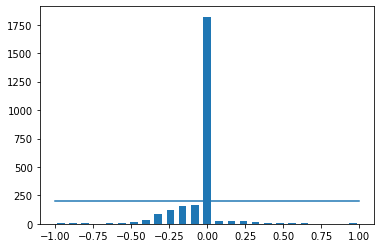

In [18]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Eliminating bias in data by removing certain plots from the data

total data: 2536
removed: 1621
remaining: 915


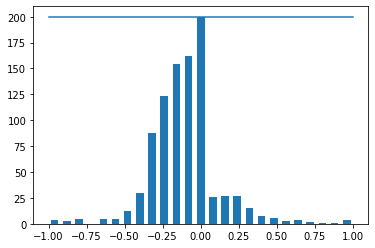

In [20]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

# **Training and Validation split**


center      center_2020_05_30_15_20_45_794.jpg
left        left_2020_05_30_15_20_45_794.jpg  
right       right_2020_05_30_15_20_45_794.jpg 
steering   -0.0542256                         
throttle    0                                 
reverse     0                                 
speed       1.05766                           
Name: 12, dtype: object
Training Samples: 2196
Valid Samples: 549


Text(0.5, 1.0, 'Validation set')

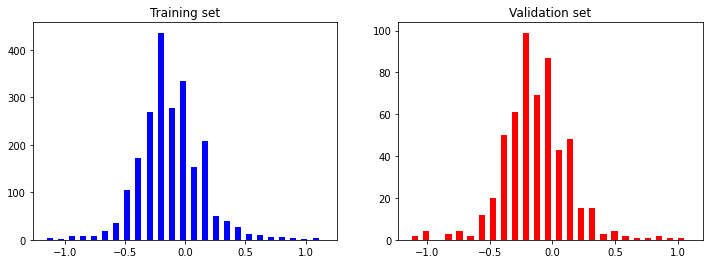

In [23]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

**preprocessing images**

TypeError: ignored

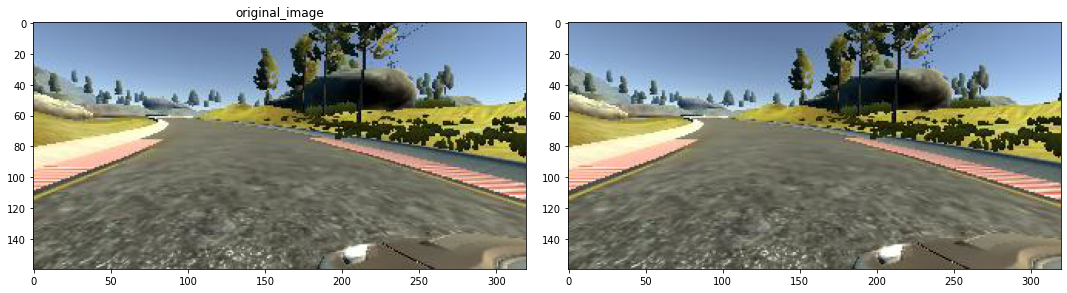

In [30]:
def img_preprocessed(img):
  img = mpimg.imread(img)
  return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocessed(image) 

fig, axis = plt.subplots(1,2,figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('original_image')
axis[1].imshow(preprocessed_image)
axis[1].imshow('preprocessed_image')